In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

/anaconda3/envs/automl/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [3]:
num_rows = None

In [4]:
# Read data and merge
df = pd.read_csv('../input/application_train.csv', nrows= num_rows)
test_df = pd.read_csv('../input/application_test.csv', nrows= num_rows)
print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
df = df.append(test_df).reset_index()


Train samples: 307511, test samples: 48744


/anaconda3/envs/automl/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [5]:
df.head()

,index,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,...,TARGET,TOTALAREA_MODE,WALLSMATERIAL_MODE,WEEKDAY_APPR_PROCESS_START,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE
0,0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0149,"Stone, brick",WEDNESDAY,0.9722,0.9722,0.9722,0.6192,0.6243,0.6341
1,1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0714,Block,MONDAY,0.9851,0.9851,0.9851,0.7960,0.7987,0.8040
2,2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,MONDAY,NaN,NaN,NaN,NaN,NaN,NaN
3,3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,WEDNESDAY,NaN,NaN,NaN,NaN,NaN,NaN
4,4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,THURSDAY,NaN,NaN,NaN,NaN,NaN,NaN


# I. application_train_test

In [6]:
# Optional: Remove 4 applications with XNA CODE_GENDER (train set)
df = df[df['CODE_GENDER'] != 'XNA']

In [7]:
# Categorical features with Binary encode (0 or 1; two categories)
for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    df[bin_feature], uniques = pd.factorize(df[bin_feature])


In [8]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Categorical features with One-Hot encode
df, cat_cols = one_hot_encoder(df, nan_as_category=True)



In [9]:
df.head()

,index,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,...,WALLSMATERIAL_MODE_Wooden,WALLSMATERIAL_MODE_nan,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,WEEKDAY_APPR_PROCESS_START_nan
0,0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
2,2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,1,0,0,0,0,0,0
3,3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,1,0
4,4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,1,0,0,0


## Add new features

In [10]:
# NaN values for DAYS_EMPLOYED: 365.243 -> nan
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
# Some simple new features (percentages)
df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

# II. bureau_and_balance

In [11]:
bureau = pd.read_csv('../input/bureau.csv', nrows = num_rows)
bb = pd.read_csv('../input/bureau_balance.csv', nrows = num_rows)

In [12]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [13]:
bb.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [14]:
bb, bb_cat = one_hot_encoder(bb, nan_as_category=True)
bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category=True)

In [15]:
# Bureau balance: Perform aggregations and merge with bureau.csv
bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
for col in bb_cat:
    bb_aggregations[col] = ['mean']


In [16]:
bb_aggregations

{'MONTHS_BALANCE': ['min', 'max', 'size'],
 'STATUS_0': ['mean'],
 'STATUS_1': ['mean'],
 'STATUS_2': ['mean'],
 'STATUS_3': ['mean'],
 'STATUS_4': ['mean'],
 'STATUS_5': ['mean'],
 'STATUS_C': ['mean'],
 'STATUS_X': ['mean'],
 'STATUS_nan': ['mean']}

In [17]:
bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)


In [18]:
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])


In [19]:
bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')


In [20]:
bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)

In [21]:
bureau.head()

,SK_ID_CURR,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,...,MONTHS_BALANCE_SIZE,STATUS_0_MEAN,STATUS_1_MEAN,STATUS_2_MEAN,STATUS_3_MEAN,STATUS_4_MEAN,STATUS_5_MEAN,STATUS_C_MEAN,STATUS_X_MEAN,STATUS_nan_MEAN
0,215354,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,215354,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,215354,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,215354,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,215354,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# Bureau and bureau_balance numeric features
num_aggregations = {
    'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
    'DAYS_CREDIT_UPDATE': ['mean'],
    'CREDIT_DAY_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean'],
    'CNT_CREDIT_PROLONG': ['sum'],
    'MONTHS_BALANCE_MIN': ['min'],
    'MONTHS_BALANCE_MAX': ['max'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum']
}


In [23]:
# Bureau and bureau_balance categorical features
cat_aggregations = {}

for cat in bureau_cat: 
    cat_aggregations[cat] = ['mean']

for cat in bb_cat: 
    cat_aggregations[cat + "_MEAN"] = ['mean']

In [24]:
bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})

In [25]:
bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])


In [26]:
# Bureau: Active credits - using only numerical aggregations
active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]


In [27]:
active.shape

(630607, 51)

In [28]:
active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)


In [29]:
active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
del active, active_agg
gc.collect()

63

In [30]:
# Bureau: Closed credits - using only numerical aggregations
closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
del closed, closed_agg, bureau
gc.collect()

106

In [31]:
bureau_agg.head()

,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,...,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_AMT_ANNUITY_MAX,CLOSED_AMT_ANNUITY_MEAN,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_MONTHS_BALANCE_MIN_MIN,CLOSED_MONTHS_BALANCE_MAX_MAX,CLOSED_MONTHS_BALANCE_SIZE_MEAN,CLOSED_MONTHS_BALANCE_SIZE_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-1572,-49,-735.000000,240043.666667,-1329.0,1778.0,82.428571,-93.142857,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-51.0,0.0,35.0,140.0
100002,-1437,-103,-874.000000,186150.000000,-1072.0,780.0,-349.000000,-499.875000,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-47.0,0.0,15.0,90.0
100003,-2586,-606,-1400.750000,827783.583333,-2434.0,1216.0,-544.500000,-816.000000,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
100004,-1326,-408,-867.000000,421362.000000,-595.0,-382.0,-488.500000,-532.000000,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
100005,-373,-62,-190.666667,26340.333333,-128.0,1324.0,439.333333,-54.333333,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-12.0,0.0,13.0,13.0


# III. previous_applications

In [32]:
prev = pd.read_csv('../input/previous_application.csv', nrows = num_rows)
prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)


In [33]:
prev.shape

(1670214, 180)

In [34]:
# Days 365.243 values -> nan
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)


In [35]:
# Add feature: value ask / value received percentage
prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']


In [36]:
# Previous applications numeric features
num_aggregations = {
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_APPLICATION': ['min', 'max', 'mean'],
    'AMT_CREDIT': ['min', 'max', 'mean'],
    'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
    'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
}
# Previous applications categorical features
cat_aggregations = {}
for cat in cat_cols:
    cat_aggregations[cat] = ['mean']



In [37]:
prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])


In [38]:
prev_agg.shape

(338857, 189)

In [39]:
# Previous Applications: Approved Applications - only numerical features
approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')


In [40]:
prev_agg.shape

(338857, 219)

In [41]:
# Previous Applications: Refused Applications - only numerical features
refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
del refused, refused_agg, approved, approved_agg, prev
gc.collect()

50

In [42]:
prev_agg.shape

(338857, 249)

# IV. pos_cash

In [43]:
pos = pd.read_csv('../input/POS_CASH_balance.csv', nrows = num_rows)
pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)


In [44]:
# Features
aggregations = {
    'MONTHS_BALANCE': ['max', 'mean', 'size'],
    'SK_DPD': ['max', 'mean'],
    'SK_DPD_DEF': ['max', 'mean']
}
for cat in cat_cols:
    aggregations[cat] = ['mean']



In [45]:
pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])


In [46]:
pos_agg.head()

,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN,POS_NAME_CONTRACT_STATUS_Approved_MEAN,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN,POS_NAME_CONTRACT_STATUS_Signed_MEAN,POS_NAME_CONTRACT_STATUS_XNA_MEAN,POS_NAME_CONTRACT_STATUS_nan_MEAN
SK_ID_CURR,,,,,,,,,,,,,,,,,
100001,-53,-72.555556,9,7,0.777778,7,0.777778,0.777778,0.0,0.0,0.0,0.222222,0.0,0.0,0.000000,0.0,0
100002,-1,-10.000000,19,0,0.000000,0,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0
100003,-18,-43.785714,28,0,0.000000,0,0.000000,0.928571,0.0,0.0,0.0,0.071429,0.0,0.0,0.000000,0.0,0
100004,-24,-25.500000,4,0,0.000000,0,0.000000,0.750000,0.0,0.0,0.0,0.250000,0.0,0.0,0.000000,0.0,0
100005,-15,-20.000000,11,0,0.000000,0,0.000000,0.818182,0.0,0.0,0.0,0.090909,0.0,0.0,0.090909,0.0,0


In [47]:
# Count pos cash accounts
pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
del pos
gc.collect()

98

# V. installments_payments

In [48]:
ins = pd.read_csv('../input/installments_payments.csv', nrows = num_rows)
ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
# Percentage and difference paid in each installment (amount paid and installment value)
ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
# Days past due and days before due (no negative values)
ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
# Features: Perform aggregations
aggregations = {
    'NUM_INSTALMENT_VERSION': ['nunique'],
    'DPD': ['max', 'mean', 'sum'],
    'DBD': ['max', 'mean', 'sum'],
    'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
    'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
    'AMT_INSTALMENT': ['max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
}
for cat in cat_cols:
    aggregations[cat] = ['mean']
ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
# Count installments accounts
ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
del ins
gc.collect()


140

# VI. credit_card_balance

In [49]:
cc = pd.read_csv('../input/credit_card_balance.csv', nrows = num_rows)
cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
# General aggregations
cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
# Count credit card lines
cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
del cc
gc.collect()

35

# VII. kfold_lightgbm

In [50]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

In [51]:
df = df.join(bureau_agg, how='left', on='SK_ID_CURR')
df = df.join(prev_agg, how='left', on='SK_ID_CURR')
df = df.join(pos_agg, how='left', on='SK_ID_CURR')
df = df.join(ins_agg, how='left', on='SK_ID_CURR')
df = df.join(cc_agg, how='left', on='SK_ID_CURR')

In [52]:
df.shape

(356251, 811)

In [53]:
# save df into local disk
df.to_csv('../input/manual_full_df.csv', index= False)

In [165]:
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv('../input/submission_baseline_2.csv', index= False)
    
    display_importances(feature_importance_df)
    return feature_importance_df


Starting LightGBM. Train shape: (307507, 811), test shape: (48744, 811)
Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.796987	training's binary_logloss: 0.234864	valid_1's auc: 0.775913	valid_1's binary_logloss: 0.246746
[400]	training's auc: 0.819424	training's binary_logloss: 0.225315	valid_1's auc: 0.786732	valid_1's binary_logloss: 0.242558
[600]	training's auc: 0.833979	training's binary_logloss: 0.219329	valid_1's auc: 0.790426	valid_1's binary_logloss: 0.241255
[800]	training's auc: 0.845859	training's binary_logloss: 0.214499	valid_1's auc: 0.792533	valid_1's binary_logloss: 0.240592
[1000]	training's auc: 0.856756	training's binary_logloss: 0.209932	valid_1's auc: 0.793509	valid_1's binary_logloss: 0.24021
[1200]	training's auc: 0.86627	training's binary_logloss: 0.20573	valid_1's auc: 0.793617	valid_1's binary_logloss: 0.240145
[1400]	training's auc: 0.87531	training's binary_logloss: 0.201695	valid_1's auc: 0.793814	valid_1's binary_lo

[1400]	training's auc: 0.875419	training's binary_logloss: 0.202472	valid_1's auc: 0.790484	valid_1's binary_logloss: 0.234277
[1600]	training's auc: 0.883499	training's binary_logloss: 0.198648	valid_1's auc: 0.790627	valid_1's binary_logloss: 0.234244
Early stopping, best iteration is:
[1514]	training's auc: 0.880027	training's binary_logloss: 0.200302	valid_1's auc: 0.790697	valid_1's binary_logloss: 0.234209
Fold  7 AUC : 0.790697
Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.797079	training's binary_logloss: 0.235163	valid_1's auc: 0.769731	valid_1's binary_logloss: 0.24559
[400]	training's auc: 0.81948	training's binary_logloss: 0.225591	valid_1's auc: 0.781225	valid_1's binary_logloss: 0.241282
[600]	training's auc: 0.83425	training's binary_logloss: 0.219531	valid_1's auc: 0.78547	valid_1's binary_logloss: 0.239808
[800]	training's auc: 0.845766	training's binary_logloss: 0.214796	valid_1's auc: 0.787493	valid_1's binary_logloss: 0.23916

/anaconda3/envs/automl/lib/python3.6/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,feature,importance,fold
0,AMT_ANNUITY,511,1
1,AMT_CREDIT,288,1
2,AMT_GOODS_PRICE,317,1
3,AMT_INCOME_TOTAL,153,1
4,AMT_REQ_CREDIT_BUREAU_DAY,8,1
5,AMT_REQ_CREDIT_BUREAU_HOUR,0,1
6,AMT_REQ_CREDIT_BUREAU_MON,17,1
7,AMT_REQ_CREDIT_BUREAU_QRT,56,1
8,AMT_REQ_CREDIT_BUREAU_WEEK,10,1
9,AMT_REQ_CREDIT_BUREAU_YEAR,45,1


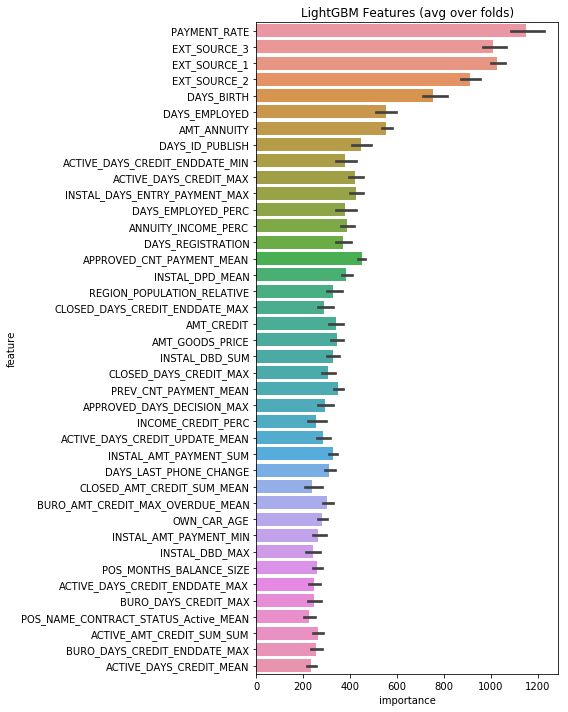

In [166]:
kfold_lightgbm(df, num_folds= 10, stratified= False, debug= False)